Ejecutando simulación para 10 trayectorias...


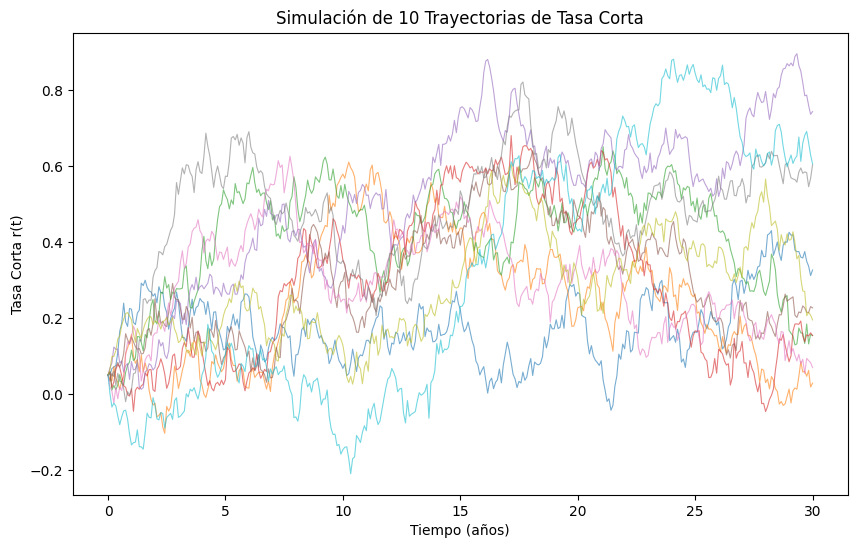


Ejecutando simulación para 1000 trayectorias para verificación...
Verificando la varianza...


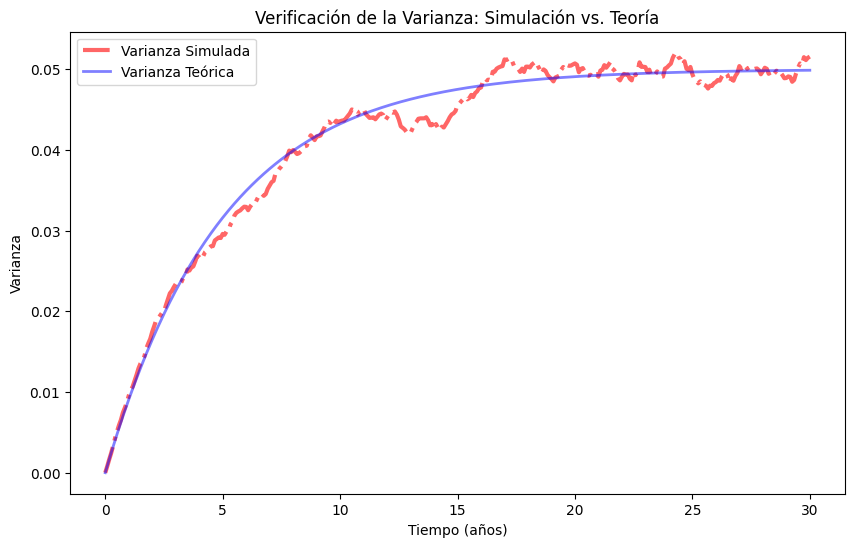

Verificando la media...


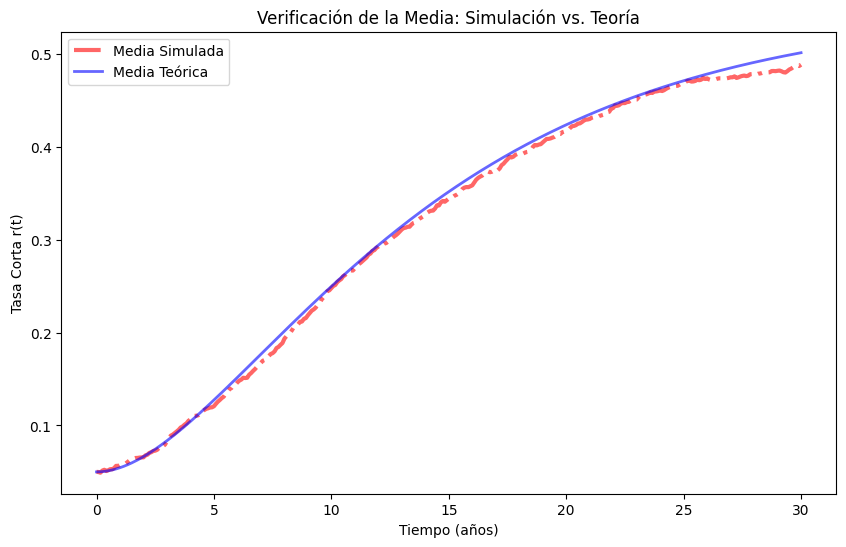

In [1]:
# --- Importaciones ---
from QuantLib import *
import matplotlib.pyplot as plt
import numpy as np

# Configuración para que los gráficos se muestren en el notebook
%matplotlib inline


# --- Clase 1: Configuración y Construcción del Modelo ---
class HullWhiteModel:
    """
    Encapsula la configuración y creación de los objetos
    del modelo Hull-White.
    Su única responsabilidad es preparar el modelo.
    """
    def __init__(self, a, sigma, forward_rate=0.05, eval_date=Date(15, 1, 2015)):
        self.a = a
        self.sigma = sigma
        self.forward_rate = forward_rate
        self.eval_date = eval_date
        self.day_count = Thirty360(Thirty360.BondBasis)

        # Configuración global de QuantLib
        Settings.instance().evaluationDate = self.eval_date

    def get_yield_curve(self):
        """Construye y devuelve la curva de tipos de interés."""
        return YieldTermStructureHandle(
            FlatForward(self.eval_date, QuoteHandle(SimpleQuote(self.forward_rate)), self.day_count)
        )

    def get_process(self):
        """Construye y devuelve el proceso estocástico de Hull-White."""
        yield_curve_handle = self.get_yield_curve()
        return HullWhiteProcess(yield_curve_handle, self.a, self.sigma)


# --- Clase 2: Motor de Simulación de Monte Carlo ---
class MonteCarloSimulator:
    """
    Realiza la simulación de Monte Carlo.
    Es agnóstico al modelo; solo necesita un proceso, una duración y los pasos.
    """
    def __init__(self, process, length, timestep):
        self.process = process
        self.length = length
        self.timestep = timestep
        self.rng = GaussianRandomSequenceGenerator(
            UniformRandomSequenceGenerator(self.timestep, UniformRandomGenerator())
        )
        self.seq_generator = GaussianPathGenerator(
            self.process, self.length, self.timestep, self.rng, False
        )

    def generate_paths(self, num_paths):
        """Genera un número específico de trayectorias."""
        arr = np.zeros((num_paths, self.timestep + 1))
        for i in range(num_paths):
            sample_path = self.seq_generator.next()
            path = sample_path.value()
            time = [path.time(j) for j in range(len(path))]
            value = [path[j] for j in range(len(path))]
            arr[i, :] = np.array(value)
        return np.array(time), arr


# --- Clase 3: Visualización de Resultados ---
class SimulationVisualizer:
    """
    Se encarga de toda la lógica para graficar los resultados.
    Su única responsabilidad es la presentación de datos.
    """
    def __init__(self, time_grid, paths):
        self.time_grid = time_grid
        self.paths = paths

    def plot_sample_paths(self, num_to_plot=10):
        """Grafica un número limitado de trayectorias simuladas."""
        plt.figure(figsize=(10, 6))
        for i in range(min(num_to_plot, len(self.paths))):
            plt.plot(self.time_grid, self.paths[i, :], lw=0.8, alpha=0.6)
        plt.title(f"Simulación de {num_to_plot} Trayectorias de Tasa Corta")
        plt.xlabel("Tiempo (años)")
        plt.ylabel("Tasa Corta r(t)")
        plt.show()

    def plot_variance_verification(self, a, sigma):
        """Compara la varianza de la simulación con la teórica."""
        simulated_var = [np.var(self.paths[:, i]) for i in range(len(self.time_grid))]
        theoretical_var = sigma * sigma / (2 * a) * (1.0 - np.exp(-2.0 * a * self.time_grid))

        plt.figure(figsize=(10, 6))
        plt.plot(self.time_grid, simulated_var, "r-.", lw=3, alpha=0.6, label="Varianza Simulada")
        plt.plot(self.time_grid, theoretical_var, "b-", lw=2, alpha=0.5, label="Varianza Teórica")
        plt.title("Verificación de la Varianza: Simulación vs. Teoría")
        plt.xlabel("Tiempo (años)")
        plt.ylabel("Varianza")
        plt.legend()
        plt.show()

    def plot_mean_verification(self, a, sigma, forward_rate):
        """Compara la media de la simulación con la teórica."""
        def theoretical_alpha(t):
            return forward_rate + 0.5 * np.power(sigma / a * (1.0 - np.exp(-a * t)), 2)

        simulated_mean = [np.mean(self.paths[:, i]) for i in range(len(self.time_grid))]
        theoretical_mean = theoretical_alpha(self.time_grid)

        plt.figure(figsize=(10, 6))
        plt.plot(self.time_grid, simulated_mean, "r-.", lw=3, alpha=0.6, label="Media Simulada")
        plt.plot(self.time_grid, theoretical_mean, "b-", lw=2, alpha=0.6, label="Media Teórica")
        plt.title("Verificación de la Media: Simulación vs. Teoría")
        plt.xlabel("Tiempo (años)")
        plt.ylabel("Tasa Corta r(t)")
        plt.legend()
        plt.show()


# --- Script principal para orquestar las clases ---
if __name__ == '__main__':
    # 1. Configurar y construir el modelo
    model_config = HullWhiteModel(a=0.1, sigma=0.1)
    hw_process = model_config.get_process()

    # 2. Instanciar el simulador con el proceso del modelo
    simulator = MonteCarloSimulator(process=hw_process, length=30, timestep=360)

    # 3. Ejecutar una simulación pequeña para visualización
    print("Ejecutando simulación para 10 trayectorias...")
    time_grid, paths_sample = simulator.generate_paths(num_paths=10)
    visualizer = SimulationVisualizer(time_grid, paths_sample)
    visualizer.plot_sample_paths(num_to_plot=10)

    # 4. Ejecutar una simulación grande para verificación estadística
    print("\nEjecutando simulación para 1000 trayectorias para verificación...")
    _, paths_large_sample = simulator.generate_paths(num_paths=1000)
    
    # 5. Visualizar los resultados de la verificación
    verifier_visualizer = SimulationVisualizer(time_grid, paths_large_sample)
    
    print("Verificando la varianza...")
    verifier_visualizer.plot_variance_verification(a=model_config.a, sigma=model_config.sigma)
    
    print("Verificando la media...")
    verifier_visualizer.plot_mean_verification(a=model_config.a, sigma=model_config.sigma, forward_rate=model_config.forward_rate)